# Traffic Light Data Processing
---

#### Resources:  
1. [Tensorflow Tutorial](https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb)
2. [Bosch Traffic Light Dataset](https://hci.iwr.uni-heidelberg.de/node/6132)

3. [TF Records tutorial guide](http://warmspringwinds.github.io/tensorflow/tf-slim/2016/12/21/tfrecords-guide/)
4. [Converting Existing Dataset to TF record](https://medium.com/@WuStangDan/step-by-step-tensorflow-object-detection-api-tutorial-part-2-converting-dataset-to-tfrecord-47f24be9248d)
5. [TF using your own dataset.md]( https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/using_your_own_dataset.md)
6. [TF Records](http://www.machinelearninguru.com/deep_learning/tensorflow/basics/tfrecord/tfrecord.html) - Example code to save TF records file

## Environment Preparation

In [1]:
### Imports ###
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

from bs4 import BeautifulSoup
import yaml

### Env setup ###
# This is needed to display the images.
%matplotlib inline

# Place TF Models repository on the same directory (https://github.com/tensorflow/models)
sys.path.append("../..")
sys.path.append("../../models/research")
sys.path.append("../../models/research/object_detection")

# Dataset folder
sys.path.append("../../dataset")

# import utils
from utils import label_map_util
from utils import visualization_utils as vis_util

## Helper Functions

In [2]:
### helper functions ###
COLOR = ['green', 'yellow', 'red']

# read xml file
def read_xml(XML_PATH):
    xml = ""
    with open(XML_PATH) as f:
        xml = f.readlines()
    
    return BeautifulSoup(''.join([line.strip('\t') for line in xml]), "lxml")

# get file name
def get_file_name(xml_info):
    return xml_info.find('filename').text

# get color id
def get_color_idx(name):
    if name=="Green":
        return 0
    elif name=="Yellow":
        return 1
    elif name=="Red":
        return 2
    return 3

# get boxes from xml
def get_detected_objects(xml_info):
    return xml_info.find_all('object')

# get image size
def get_img_size(xml_info):
    return (int(xml_info.size.width.text), int(xml_info.size.height.text))

# get detected object's color
def get_object_color(obj):
    return obj.find('name').text

# get bounds from boxes
def get_boxbounds(obj):
    xmin = int(obj.bndbox.xmin.text)
    ymin = int(obj.bndbox.ymin.text)
    xmax = int(obj.bndbox.xmax.text)
    ymax = int(obj.bndbox.ymax.text)
    return (xmin, ymin, xmax, ymax)

# plot annotations
def plot_annotation(IMG_PATH, XML_PATH):
    # read image and xml
    img = Image.open(IMG_PATH)
    xml_info = read_xml(XML_PATH)
    detected_objects = get_detected_objects(xml_info)
    
    # draw boxes
    for k in range(len(detected_objects)):
        # get detection info
        c = get_object_color(detected_objects[k])
        bounds = get_boxbounds(detected_objects[k])
        color_idx = get_color_idx(c)
        
        # draw box on image
        vis_util.draw_bounding_box_on_image(
        img, bounds[1], bounds[0], bounds[3], bounds[2],
        color=COLOR[color_idx], display_str_list=(str(k+1)),
        use_normalized_coordinates = False)
    
    # plot image
    plt.imshow(img)
    plt.show()
    
# plot annotations
def plot_annotation_bosch(YAML_IMG):
    
    img = Image.open(YAML_IMG['path'])
    detected_objects = YAML_IMG['boxes']
    
    # draw boxes
    for i in range(len(detected_objects)):
        # get detection info
        c = detected_objects[i]['label']
        color_idx = get_color_idx(c)
        
        # get annotation bounds
        xmin = int(detected_objects[i]['x_min']) 
        xmax = int(detected_objects[i]['x_max'])
        ymin = int(detected_objects[i]['y_min'])
        ymax = int(detected_objects[i]['y_max'])
        
        # draw box on image
        vis_util.draw_bounding_box_on_image(
        img, ymin, xmin, ymax, xmax,
        color=COLOR[color_idx], display_str_list=(str(i+1)),
        thickness = 6,
        use_normalized_coordinates = False)
    
    # plot image
    plt.figure(figsize=(20,10))
    plt.imshow(img)
    plt.show()

## Data Exploration

In [3]:
### Loading label map ###
NUM_CLASSES = 4
PATH_TO_LABELS = '../../dataset/label_map.pbtxt'

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'id': 1, 'name': 'Green'}, 2: {'id': 2, 'name': 'Red'}, 3: {'id': 3, 'name': 'Yellow'}, 4: {'id': 4, 'name': 'off'}}


In [4]:
### Loading images ###
# image path
PATH_TO_GREEN_IMGS = "../../dataset/images_for_training/green/"
PATH_TO_RED_IMGS = "../../dataset/images_for_training/red/"
PATH_TO_YELLOW_IMGS = "../../dataset/images_for_training/yellow/"
PATH_TO_XML = "../../dataset/images_for_training/"

# get images list
green_images_list = os.listdir(PATH_TO_GREEN_IMGS)
yellow_images_list = os.listdir(PATH_TO_YELLOW_IMGS)
red_images_list = os.listdir(PATH_TO_RED_IMGS)

num_green_imgs = len(green_images_list)
num_yellow_imgs = len(yellow_images_list)
num_red_imgs = len(red_images_list)

# Images Summary
print("Train images count: Green - {}, Yellow - {}, Red - {}".format(num_green_imgs, num_yellow_imgs, num_red_imgs) )

Train images count: Green - 196, Yellow - 147, Red - 174


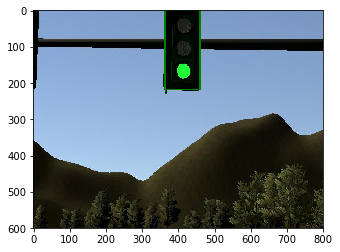

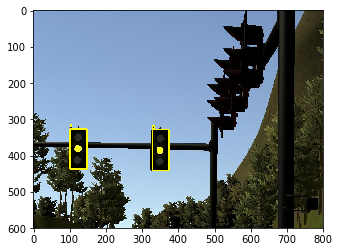

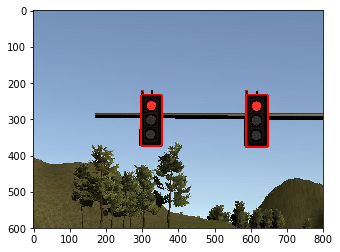

In [5]:
### Check Traffic Sign Annotations ###
# Pick Index
green_idx = 1
yellow_idx = 0
red_idx = 0

# get image name
green_img = green_images_list[green_idx]
yellow_img = yellow_images_list[yellow_idx]
red_img = red_images_list[red_idx]

# plot image
# green folder image
plot_annotation(PATH_TO_GREEN_IMGS + green_img, PATH_TO_XML + green_img.split('.')[0] + '.xml')
# yellow folder image
plot_annotation(PATH_TO_YELLOW_IMGS + yellow_img, PATH_TO_XML + yellow_img.split('.')[0] + '.xml')
# red folder image
plot_annotation(PATH_TO_RED_IMGS + red_img, PATH_TO_XML + red_img.split('.')[0] + '.xml')

In [6]:
### TF Records Conversion ###
import tensorflow as tf
from utils import dataset_util

# convert to TFRecords format
def create_tf_example(XML_Path):
    
    # read xml info
    xml_info = read_xml(XML_Path)
    img_size = get_img_size(xml_info)
    file_name = get_file_name(xml_info)
    detected_objects = get_detected_objects(xml_info)
    
    height = img_size[1] # Image height
    width = img_size[0] # Image width
    filename = file_name # Filename of the image. Empty if image is not from file
    encoded_image_data = None # Encoded image bytes
    image_format = b'png' # b'jpeg' or b'png'

    xmins = [] # List of normalized left x coordinates in bounding box (1 per box)
    xmaxs = [] # List of normalized right x coordinates in bounding box
             # (1 per box)
    ymins = [] # List of normalized top y coordinates in bounding box (1 per box)
    ymaxs = [] # List of normalized bottom y coordinates in bounding box
             # (1 per box)
    
    classes_text = [] # List of string class name of bounding box (1 per box)
    classes = [] # List of integer class id of bounding box (1 per box)
    
    # loop through each detection
    for i in range(len(detected_objects)):
        # get detection info
        color = get_object_color(detected_objects[i])
        bounds = get_boxbounds(detected_objects[i])
        color_idx = get_color_idx(color)
        
        xmins += [bounds[0]]
        ymins += [bounds[1]]
        xmaxs += [bounds[2]]
        ymaxs += [bounds[3]]
        
        classes_text += [color]
        classes += [color_idx]
    
    tf_example = tf.train.Example(features=tf.train.Features(feature={
      'image/height': dataset_util.int64_feature(height),
      'image/width': dataset_util.int64_feature(width),
      'image/filename': dataset_util.bytes_feature(filename),
      'image/source_id': dataset_util.bytes_feature(filename),
      'image/encoded': dataset_util.bytes_feature(encoded_image_data),
      'image/format': dataset_util.bytes_feature(image_format),
      'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
      'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
      'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
      'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
      'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
      'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

In [7]:
# get all XML files
xml_list = os.listdir(PATH_TO_XML)

train_filename = 'train.tfrecords'  # address to save the TFRecords file

# open the TFRecords file
writer = tf.python_io.TFRecordWriter(train_filename)

for i in range(len(xml_list)):
    xml_path = PATH_TO_XML + xml_list[i]
    tf_example = create_tf_example(xml_path)
    writer.write(tf_example.SerializeToString())

writer.close()

TypeError: 'green_1035.png' has type <class 'str'>, but expected one of: ((<class 'bytes'>,),)

## BOSCH Traffic Light Dataset

In [8]:
Labels = ["Green", "Yellow", "Red", "off"]
yaml_path = "../../dataset/test.yaml"

def keep_label(label):
    if label in Labels:
        return True
    return False
    
def get_tl_labels(input_yaml, riib=False):
    """ Gets all labels within label file
    Note that RGB images are 1280x720 and RIIB images are 1280x736.
    :param input_yaml: Path to yaml file
    :param riib: If True, change path to labeled pictures
    :return: images: Labels for traffic lights
    """
    
    images = yaml.load(open(input_yaml, 'rb').read())
    print("total images: {}".format(len(images)))
    images_filtered = []
    
    for i in range(len(images)):
        detections = images[i]['boxes']
        detect_count= 0
        
        for j in range(len(detections)):
            # count only traffic lights (G,Y,R,off)
            if keep_label(detections[j]['label']):
                detect_count += 1
            else:
                # just skip if other labels are found
                detect_count -= 5
        
        # save image if detection exist
        if detect_count > 0:
            file_name = os.path.basename(images[i]['path'])
            images[i]['path'] = os.path.abspath(os.path.join('../../dataset/rgb/test/', file_name))
            images_filtered.append(images[i])
    
    return images_filtered

In [9]:
### Import dataset ###
image_filtered = get_tl_labels(yaml_path)

total images: 8334


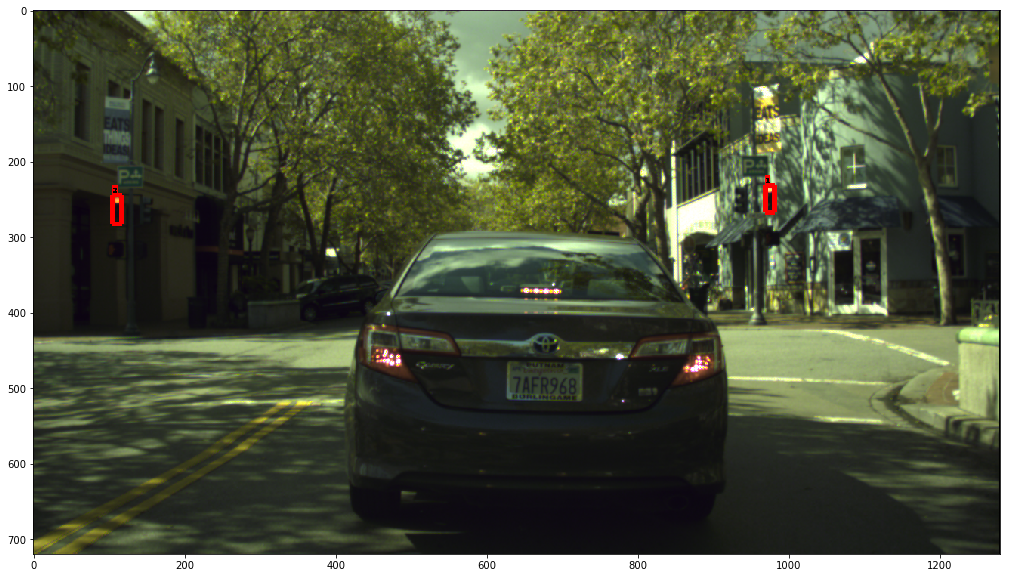

In [10]:
### Plot ###
# Pick an index
test_img_idx = 6500

# Plot
plot_annotation_bosch(image_filtered[6500])